In [28]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [29]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_go_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_go_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([0])
          ivddio = np.array([0])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_go_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_go_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65535):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_go_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_pba_1165
1bpc_bwa_0
[[ 424908  951328]
 [   1252 1374982]]
[[ 840174  536062]
 [   1288 1374946]]
[[1088283  287953]
 [   1243 1374991]]
[[1231669  144567]
 [   1236 1374998]]
[[1272267  103969]
 [   1165 1375069]]
[[1286720   89516]
 [   1203 1375031]]
[[1292126   84110]
 [   1162 1375072]]
[[1294826   81410]
 [   1198 1375036]]
[[1296110   80126]
 [   1228 1375006]]
[[1297155   79081]
 [   1376 1374858]]
[[1298512   77724]
 [   1562 1374672]]
[[1300181   76055]
 [   1799 1374435]]
[[1093545  283160]
 [   1023 1374742]]
[[1235889  140816]
 [   1022 1374743]]
[[1275049  101656]
 [    992 1374773]]
[[1299258   77447]
 [    923 1374842]]
[[1307108   69597]
 [    899 1374866]]
[[1310099   66606]
 [    921 1374844]]
[[1310805   65900]
 [    906 1374859]]
[[1311138   65567]
 [    942 1374823]]
[[1311262   65443]
 [    994 1374771]]
[[1311803   64902]
 [    995 1374770]]
[[1312384   64321]
 [   1103 1374662]]
[[1312727   63978]
 [   1164 1374601]]
1bpc_bwa_1
[[ 996341  380364]
 [    626

,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_0_cb,1,1,6.1642005443573,0.052429,0.002996,5.706034e-11,1.086892e-18,5.249864e+07,0.346082,...,0.588287,65536,2701715,327680,65536,65536,5242936,4128768,1326501,1375214
1,1bpc_bwa_0_cb,2,1,8.751277446746826,0.077949,0.002989,8.465958e-11,2.397533e-18,3.531112e+07,0.195225,...,0.441842,65536,912666,458777,66639,129864,7794909,8201729,1322871,2283524
2,1bpc_bwa_0_cb,4,1,12.432687759399414,0.107033,0.002996,1.165030e-10,4.530372e-18,2.571598e+07,0.105068,...,0.324142,65536,414558,583723,68506,243550,10703343,9820607,1323472,3205339
3,1bpc_bwa_0_cb,8,1,18.48015308380127,0.152248,0.002995,1.656893e-10,9.164830e-18,1.807882e+07,0.052972,...,0.230156,65536,142630,777630,72359,420215,15224833,10856316,1326754,3684156
4,1bpc_bwa_0_cb,16,1,25.349833965301514,0.222305,0.002998,2.421608e-10,1.955826e-17,1.238151e+07,0.038196,...,0.195439,65536,72484,1072882,79136,702022,22230486,11457992,1333373,4068887
5,1bpc_bwa_0_cb,32,1,40.05065941810608,0.350800,0.003014,3.841646e-10,4.896147e-17,7.846262e+06,0.032959,...,0.181546,65536,52243,1610918,92686,1224001,35080015,12249463,1347057,4773817
6,1bpc_bwa_0_cb,64,1,70.20919251441956,0.601950,0.003004,6.570442e-10,1.436919e-16,4.572592e+06,0.030980,...,0.176012,65536,46112,2660977,119016,2246900,60194967,13642514,1373518,6116902
7,1bpc_bwa_0_cb,128,1,126.5936861038208,1.098096,0.002996,1.195390e-09,4.768999e-16,2.506585e+06,0.030012,...,0.173241,65536,44377,4734530,168202,4270921,109809579,16366476,1422844,8782519
8,1bpc_bwa_0_cb,256,1,241.2784492969513,2.088591,0.003012,2.285499e-09,1.734250e-15,1.317860e+06,0.029557,...,0.171921,65536,43862,8873845,265758,8312526,208859091,21953367,1521387,14267136
9,1bpc_bwa_0_cb,512,1,465.7865164279938,4.061624,0.003022,4.460004e-09,6.581309e-15,6.776772e+05,0.029231,...,0.170970,65536,43504,17119019,458855,16364429,406162374,33124535,1715671,25240032


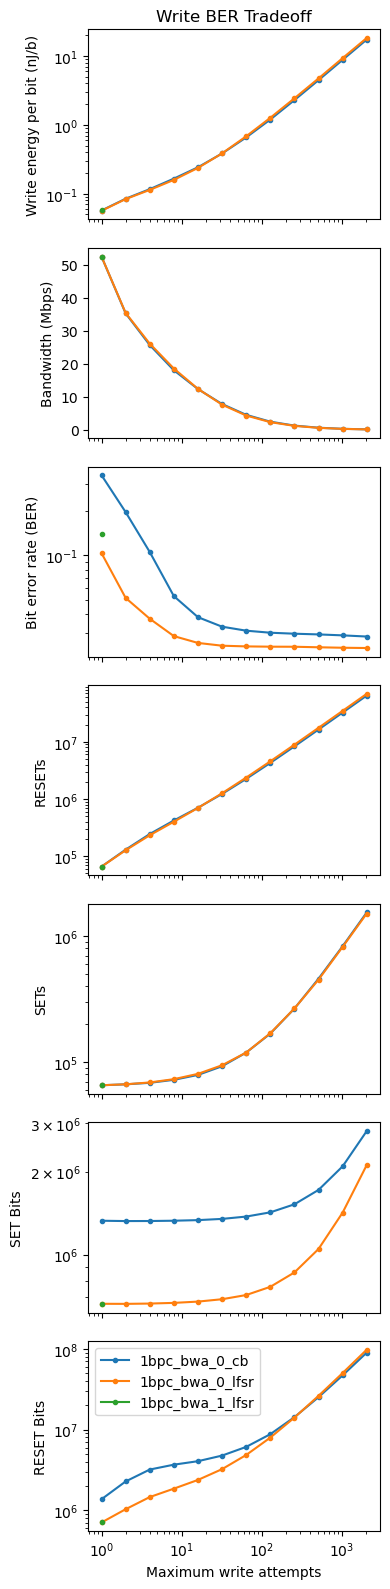

In [30]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()